In [0]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(2)
import pandas as pd
from multiprocessing import  Pool
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sliced import SlicedInverseRegression
from sklearn.model_selection import validation_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso

# Load Data

In [0]:
hta20 = pd.read_csv('/home/ltt2114_columbia_edu/HTA20.csv').transpose()
new_header = hta20.iloc[0] #grab the first row for the header
hta20 = hta20[1:] #take the data less the header row
hta20.columns = new_header #set the header row as the df header

In [0]:
hugene21st = pd.read_csv('/home/ltt2114_columbia_edu/HuGene21ST.csv').transpose()
new_header = hugene21st.iloc[0] #grab the first row for the header
hugene21st = hugene21st[1:] #take the data less the header row
hugene21st.columns = new_header #set the header row as the df header

In [0]:
metadata = pd.read_csv('/home/ltt2114_columbia_edu/anoSC2_v20_nokey.csv',index_col='SampleID')

In [0]:
#hta20.columns[[c not in hugene21st.columns for c in hta20.columns]]
#hta20.loc[:,hta20.columns[[c not in hugene21st.columns for c in hta20.columns]]]
df = pd.concat([hta20.loc[:,hta20.columns[[c in hugene21st.columns for c in hta20.columns]]],hugene21st.loc[:,hugene21st.columns[[c in hta20.columns for c in hugene21st.columns]]]])
#df1 = hugene21st.join(hta20.loc[:,hta20.columns[[c not in hugene21st.columns for c in hta20.columns]]],how='inner')
#df2 = hta20.join(hugene21st.loc[:,hugene21st.columns[[c not in hta20.columns for c in hugene21st.columns]]],how='left')


# Feature Selection

In [0]:
#ros = RandomOverSampler(random_state=42)
X = metadata.loc[metadata.Train == True][['GA']].join(df,how='left')
X = X.drop(columns='GA')
y = metadata.loc[metadata.Train == True][['GADel','TTD','Group']]
y['pprom'] = (y.Group=='PPROM').astype(int)
y['sptd'] = (y.Group=='sPTD').astype(int)
y['preterm'] = (np.logical_or(y.Group=='sPTD',y.Group=='PPROM')).astype(int)
#X_resampled, y_resampled = ros.fit_resample(X, y)
X_train = {}
X_val = {}
X_test = {}
X_train['complete'],X_test['complete'],y_train,y_test = train_test_split(X,y,test_size=0.15, random_state=42)
X_train['complete'],X_val['complete'],y_train,y_val = train_test_split(X_train['complete'],y_train,test_size=0.18, random_state=42)

In [0]:
def f_feature_selection(y,threshold=.5):
  p_vals = f_classif(X_train['complete'],y)[1]
  return X_train['complete'].loc[:,p_vals<threshold],X_val['complete'].loc[:,p_vals<threshold],X_test['complete'].loc[:,p_vals<threshold]

In [0]:
# genes cited in literature as impacting preterm birth
known=['1182_at','27071_at', '5473_at','56911_at','92597_at','5874_at','64407_at','131540_at','3248_at','92342_at','23015_at']
X_train['known'] = X_train['complete'].loc[:,known]
X_val['known'] = X_val['complete'].loc[:,known]
X_test['known'] = X_test['complete'].loc[:,known]

In [0]:
X_train['pprom'], X_val['pprom'], X_test['pprom'] = f_feature_selection(y_train['pprom'])
X_train['sptd'], X_val['sptd'], X_test['sptd'] = f_feature_selection(y_train['sptd'])
X_train['preterm'], X_val['sptd'], X_test['sptd'] = f_feature_selection(y_train['preterm'])

In [0]:
p_vals_ttd = f_regression(X_train['complete'],y_train['TTD'])[1]
X_train['ttd'] = X_train['complete'].loc[:,p_vals_ttd < .005]
X_val['ttd'] = X_val['complete'].loc[:,p_vals_ttd < .005]
X_test['ttd'] = X_test['complete'].loc[:,p_vals_ttd < .005]

In [0]:
pca_dims = [10,50,100,250]
pca = {}
X_train['pca'] = {}
X_val['pca'] = {}
X_test['pca'] = {}
X_train['pca_plus'] = {}
X_val['pca_plus'] = {}
X_test['pca_plus'] = {}
for k in pca_dims:
  pca[k] = PCA(n_components=k).fit(X_train['complete'])
  X_train['pca'][k] = pd.DataFrame(pca[k].transform(X_train['complete']),index=X_train['complete'].index)
  X_val['pca'][k] = pd.DataFrame(pca[k].transform(X_val['complete']),index=X_val['complete'].index)
  X_test['pca'][k] = pd.DataFrame(pca[k].transform(X_test['complete']),index=X_test['complete'].index)
  X_train['pca_plus'][k] = X_train['known'].join(X_train['pca'][k],how='inner')
  X_val['pca_plus'][k] = X_val['known'].join(X_val['pca'][k],how='inner')
  X_test['pca_plus'][k] = X_test['known'].join(X_test['pca'][k],how='inner')

In [0]:
#sir = SlicedInverseRegression(n_slices=2).fit(X_train,y_train['pprom'])
#X_train_pprom_sir = sir.transform(X_train_pprom)
#X_test_pprom_sir = sir.transform(X_test_pprom)

# Validation Curves

In [0]:
def vary_classifier_1d(classifier,param_name,param_range,X,y,ax,boost=False):
  train_scores,test_scores = validation_curve(classifier,X,y,param_name,param_range,cv=3,n_jobs=-1,scoring='roc_auc',verbose=0)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  #plt.title("Validation Curve with SVM")
  #plt.xlabel(r"$\gamma$")
  #plt.ylabel("Score")
  #ax.ylim(0.5, 1)
  lw = 2
  if boost==True:
    param_range = [1,2,3,5,7]
  ax.plot(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
  ax.fill_between(param_range, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.2,
                  color="darkorange", lw=lw)
  ax.plot(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
  ax.fill_between(param_range, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.2,
                  color="navy", lw=lw)
  #plt.legend(loc="best")
  #plt.show()

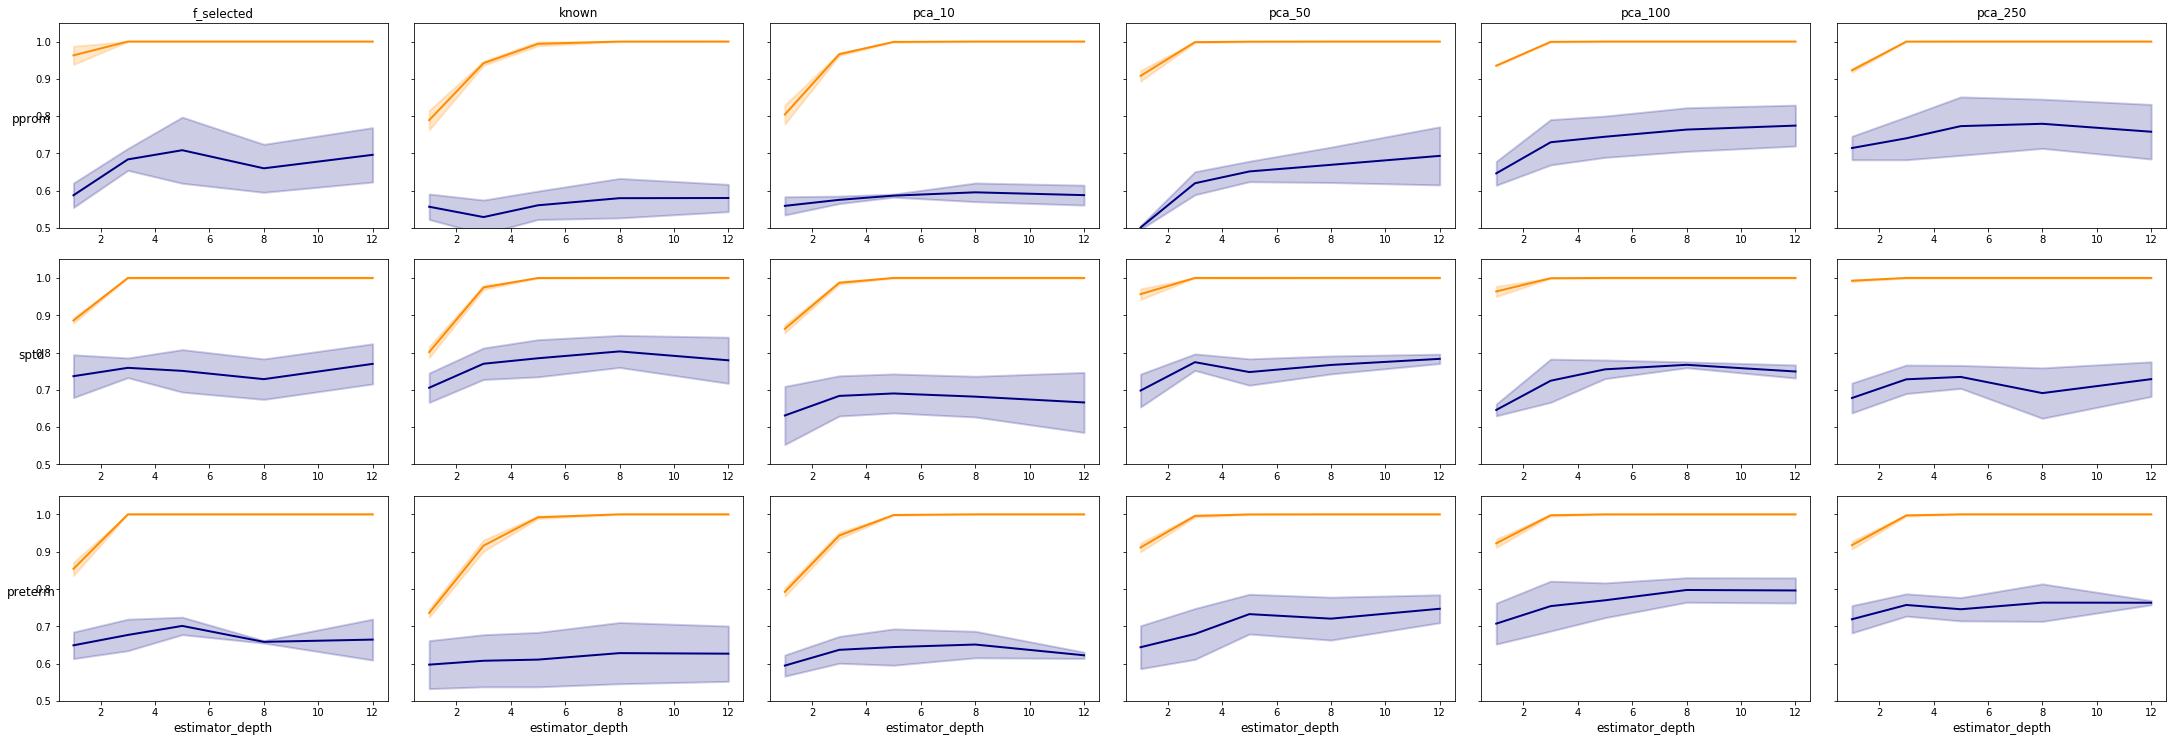

<Figure size 432x288 with 0 Axes>

In [14]:
depths = [1,3,5,8,12]

f, ax = plt.subplots(3, 6, sharey=True,figsize=(30,10))
plt.setp(ax, ylim=(.5,1.05))
f.tight_layout()
treatments = ['f_selected','known','pca_10','pca_50','pca_100','pca_250']
targets = ['pprom','sptd','preterm']
for j in range(len(treatments)):
  ax[0][j].set_title(treatments[j])
for i in range(len(targets)):
  ax[i][0].set_ylabel(targets[i],rotation=0,size='large')
for j in range(len(treatments)):
  ax[len(targets)-1][j].set_xlabel('estimator_depth',size='large')
j = 0
for target in targets:
  l = [target]
  l.extend(['known'])
  i = 0
  for featureset in l:
    vary_classifier_1d(RandomForestClassifier(n_estimators=100,n_jobs=-1,min_samples_leaf=1,max_features=.5,class_weight='balanced'),'max_depth',depths,X_train[featureset],y_train[target],ax[j][i])
    i += 1
  for dim in pca_dims:
    vary_classifier_1d(RandomForestClassifier(n_estimators=100,n_jobs=-1,min_samples_leaf=1,max_features=.5,class_weight='balanced'),'max_depth',depths,X_train['pca'][dim],y_train[target],ax[j][i])
    i += 1
  j += 1
plt.show()
plt.savefig('rf_depth_validation_curves.png')

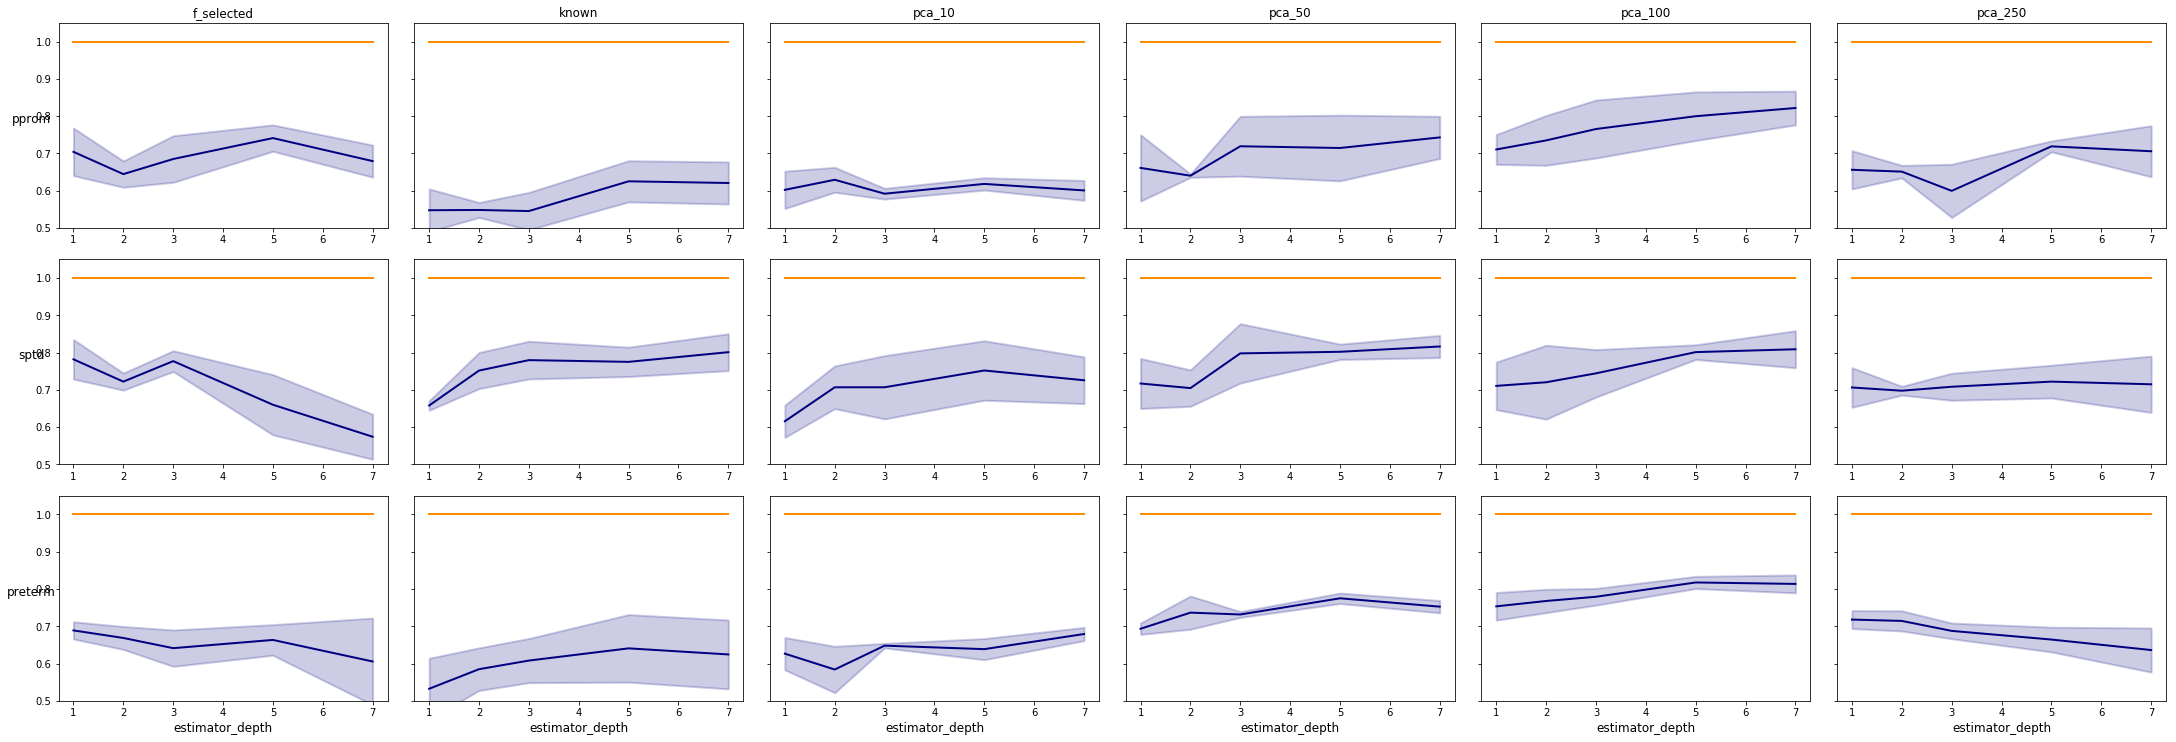

<Figure size 432x288 with 0 Axes>

In [15]:
estimators = [DecisionTreeClassifier(max_depth=d) for d in [1,2,3,5,7]]

f, ax = plt.subplots(3, 6, sharey=True,figsize=(30,10))
plt.setp(ax, ylim=(.5,1.05))
f.tight_layout()
treatments = ['f_selected','known','pca_10','pca_50','pca_100','pca_250']
targets = ['pprom','sptd','preterm']
for j in range(len(treatments)):
  ax[0][j].set_title(treatments[j])
for i in range(len(targets)):
  ax[i][0].set_ylabel(targets[i],rotation=0,size='large')
for j in range(len(treatments)):
  ax[len(targets)-1][j].set_xlabel('estimator_depth',size='large')
j = 0
for target in targets:
  l = [target]
  l.extend(['known'])
  i = 0
  for featureset in l:
    vary_classifier_1d(AdaBoostClassifier(n_estimators=100),'base_estimator',estimators,X_train[featureset],y_train[target],ax[j][i],boost=True)
    i += 1
  for dim in pca_dims:
    vary_classifier_1d(AdaBoostClassifier(n_estimators=100),'base_estimator',estimators,X_train['pca'][dim],y_train[target],ax[j][i],boost=True)
    i += 1
  j += 1
plt.show()
plt.savefig('adaboost_depth_validation_curves.png')

# Fine tuning/Grid search

In [0]:
def grid_search_plot_roc(classifier,params,X_t,y_t,X_v,y_v,title):
  m = GridSearchCV(estimator=classifier,param_grid=params,cv=3,n_jobs=-1,scoring='roc_auc',verbose=0).fit(X_t,y_t)
  print('Best params: ' + str(m.best_params_))
  clf = m.best_estimator_
  print("Best model's mean training AUC:" + str(m.best_score_))
  preds = clf.predict(X_v)
  print("Best model's validation accuracy: " + str(accuracy_score(preds,y_v)))
  probs = clf.predict_proba(X_v)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_v, preds)
  roc_auc = auc(fpr, tpr)
  print("Best model's generalization AUC: " + str(roc_auc))
  plt.title(title)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return clf

## Predicting PPROM

Best params: {'min_samples_leaf': 1, 'class_weight': 'balanced', 'n_jobs': -1, 'n_estimators': 2000, 'max_features': 0.05, 'max_depth': 11}
Best model's mean training AUC:0.8304548794826573
Best model's validation accuracy: 0.746268656716418
Best model's generalization AUC: 0.7129411764705883


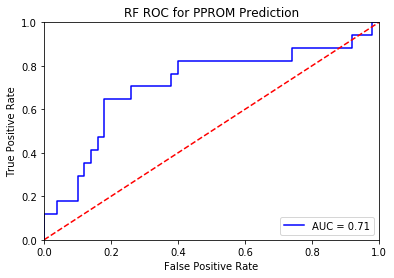

In [17]:
params_rf = {'n_estimators':[2000],'max_features':[.01,.05,.25,.5],'max_depth':[7,9,11],'n_jobs':[-1],'min_samples_leaf':[1],'class_weight':['balanced']}
rf_pprom = grid_search_plot_roc(RandomForestClassifier(),params_rf,X_train['pca_plus'][100],y_train['pprom'],X_val['pca_plus'][100],y_val['pprom'],'RF ROC for PPROM Prediction')

## Predicting sPTD

Best params: {'min_samples_leaf': 1, 'class_weight': 'balanced', 'n_jobs': -1, 'n_estimators': 2000, 'max_features': 0.25, 'max_depth': 11}
Best model's mean training AUC:0.8042219952332311
Best model's validation accuracy: 0.8805970149253731
Best model's generalization AUC: 0.8119047619047619


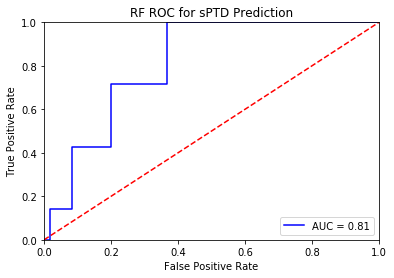

In [18]:
params_rf = {'n_estimators':[2000],'max_features':[.01,.05,.25,.5],'max_depth':[7,9,11],'n_jobs':[-1],'min_samples_leaf':[1],'class_weight':['balanced']}
rf_sptd = grid_search_plot_roc(RandomForestClassifier(),params_rf,X_train['pca_plus'][100],y_train['sptd'],X_val['pca_plus'][100],y_val['sptd'],'RF ROC for sPTD Prediction')

## Predicting any preterm labor

Best params: {'min_samples_leaf': 1, 'class_weight': 'balanced', 'n_jobs': -1, 'n_estimators': 2000, 'max_features': 0.05, 'max_depth': 11}
Best model's mean training AUC:0.8328398676664341
Best model's validation accuracy: 0.6716417910447762
Best model's generalization AUC: 0.7315891472868217


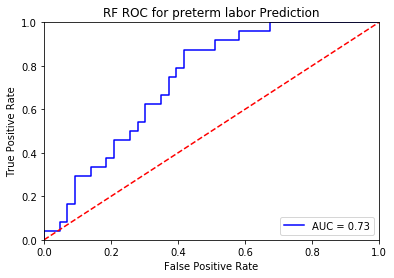

In [19]:
params_rf = {'n_estimators':[2000],'max_features':[.01,.05,.25,.5],'max_depth':[7,9,11],'n_jobs':[-1],'min_samples_leaf':[1],'class_weight':['balanced']}
rf_preterm = grid_search_plot_roc(RandomForestClassifier(),params_rf,X_train['pca_plus'][100],y_train['preterm'],X_val['pca_plus'][100],y_val['preterm'],'RF ROC for preterm labor Prediction')

## Regression for Time to Delivery

R^2 value=0.27050405706176417


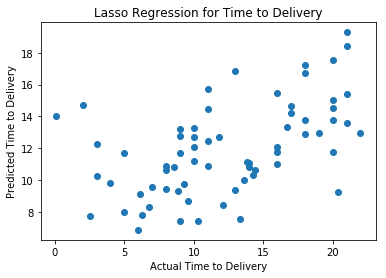

In [20]:
lasso_ttd = Lasso(alpha=.01).fit(X_train['pca_plus'][100],y_train['TTD'])
print("R^2 value="+str(lasso_ttd.score(X_val['pca_plus'][100],y_val['TTD'])))
preds = lasso_ttd.predict(X_val['pca_plus'][100])
actual = y_val['TTD']
plt.scatter(actual,preds)
plt.xlabel('Actual Time to Delivery')
plt.ylabel('Predicted Time to Delivery')
plt.title('Lasso Regression for Time to Delivery')
plt.savefig('regression_scatter.png')

# Results and Method Comparison

In [0]:
from copy import deepcopy
def train_plot_roc(classifier,X_t,y_t,X_v,y_v,ax):
  clf = classifier.fit(X_t,y_t)
  preds = clf.predict(X_v)
  print("Best model's validation accuracy: " + str(accuracy_score(preds,y_v)))
  probs = clf.predict_proba(X_v)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_v, preds)
  roc_auc = auc(fpr, tpr)
  print("Best model's generalization AUC: " + str(roc_auc))
  ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  ax.legend(loc = 'lower right')
  ax.plot([0, 1], [0, 1],'r--')
  return deepcopy(clf)

Random Forest PPROM:
Best model's validation accuracy: 0.7424242424242424
Best model's generalization AUC: 0.801920768307323
Random Forest sPTD:
Best model's validation accuracy: 0.8333333333333334
Best model's generalization AUC: 0.7160493827160493
Random Forest Preterm:
Best model's validation accuracy: 0.6666666666666666
Best model's generalization AUC: 0.7474370922646785
AdaBoost PPROM:
Best model's validation accuracy: 0.7424242424242424
Best model's generalization AUC: 0.836734693877551
AdaBoost sPTD:
Best model's validation accuracy: 0.8333333333333334
Best model's generalization AUC: 0.8395061728395061
AdaBoost Preterm:
Best model's validation accuracy: 0.6666666666666666
Best model's generalization AUC: 0.8191985088536813


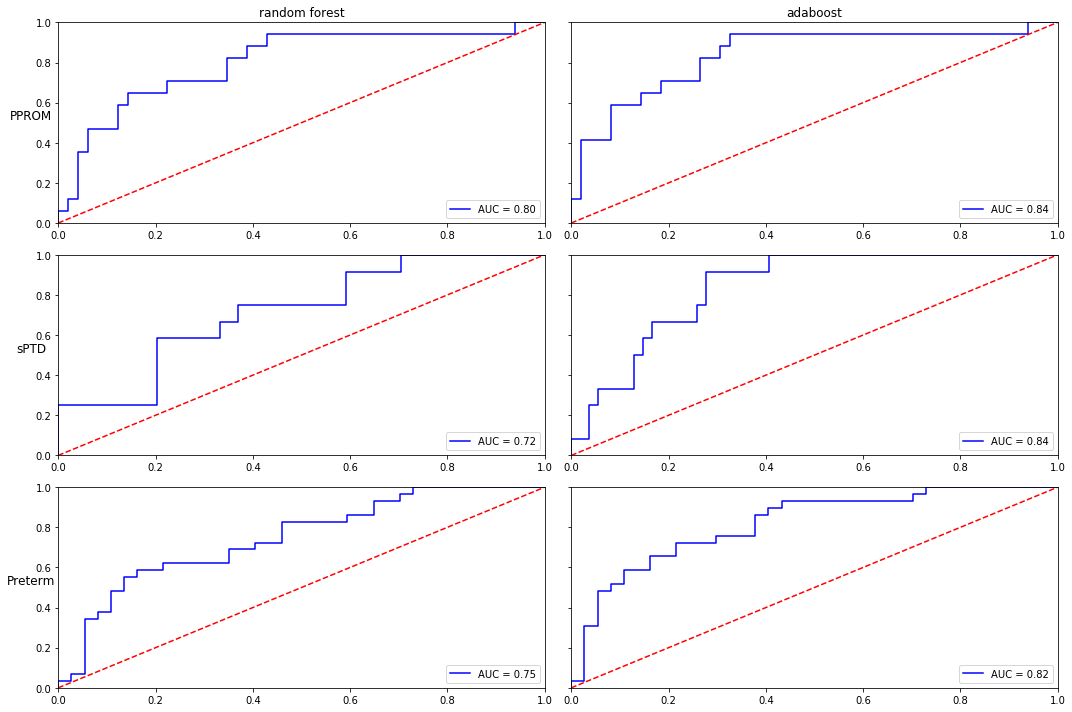

<Figure size 432x288 with 0 Axes>

In [22]:
ada_pprom = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=2000)
ada_sptd = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=2000)
ada_preterm = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=2000)
f, ax = plt.subplots(3, 2, sharey=True,figsize=(15,10))
plt.setp(ax, xlim=(0,1),ylim=(0,1))
ax[0][0].set_title('random forest')
ax[0][1].set_title('adaboost')
ax[0][0].set_ylabel('PPROM',rotation=0,size='large')
ax[1][0].set_ylabel('sPTD',rotation=0,size='large')
ax[2][0].set_ylabel('Preterm',rotation=0,size='large')
f.tight_layout()
X_final = pd.concat([X_train['pca_plus'][100],X_val['pca_plus'][100]])
y_final = pd.concat([y_train,y_val])
print('Random Forest PPROM:')
rf_pprom = train_plot_roc(rf_pprom,X_final,y_final['pprom'],X_test['pca_plus'][100],y_test['pprom'],ax[0][0])
print('Random Forest sPTD:')
rf_sptd= train_plot_roc(rf_sptd,X_final,y_final['sptd'],X_test['pca_plus'][100],y_test['sptd'],ax[1][0])
print('Random Forest Preterm:')
rf_preterm = train_plot_roc(rf_preterm,X_final,y_final['preterm'],X_test['pca_plus'][100],y_test['preterm'],ax[2][0])
print('AdaBoost PPROM:')
ada_pprom = train_plot_roc(ada_pprom,X_final,y_final['pprom'],X_test['pca_plus'][100],y_test['pprom'],ax[0][1])
print('AdaBoost sPTD:')
ada_sptd = train_plot_roc(ada_sptd,X_final,y_final['sptd'],X_test['pca_plus'][100],y_test['sptd'],ax[1][1])
print('AdaBoost Preterm:')
ada_preterm = train_plot_roc(ada_preterm,X_final,y_final['preterm'],X_test['pca_plus'][100],y_test['preterm'],ax[2][1])
plt.show()
plt.savefig('final_auc.png')

# Model Intepretation

In [0]:
def get_most_important_genes(model):
  importance_v = [0]*len(X.columns)
  vecs = [pca[100].inverse_transform(np.eye(100)[i]) for i in range(100)]
  for i in range(len(model.feature_importances_)):
    if '_' not in str(X_final.columns[i]):
      d = (model.feature_importances_[i] * vecs[int(X_final.columns[i])])
      importance_v += d
    else:
      d = (model.feature_importances_[i] * np.eye(len(X.columns))[X.columns.get_loc(X_final.columns[i])])
      importance_v += d
  return X.columns[np.argsort(-importance_v)[:10]]

In [24]:
print("Ten most significant gene expressions: "+ str(get_most_important_genes(ada_pprom)))

Ten most significant gene expressions: Index(['3039_at', '3043_at', '51629_at', '7305_at', '212_at', '4946_at',
       '4069_at', '665_at', '51094_at', '2512_at'],
      dtype='object')
